# AIPI 590 - XAI | Assignment #03
### Churn Prediction with Interpretability 
### Akhil Chintalapati

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1zR-MpNQiSzehvNgvy2aiAouFbaQ0i_t2?usp=sharing)

In [ ]:
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "ChurnPredictor" # Change to your repo name
git_path = 'https://github.com/AkhilByteWrangler/ChurnPredictor.git' #Change to your path
!git clone "{git_path}"

# Change working directory to location of notebook
notebook_dir = 'templates'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

# Step 0 : Importing the Required Libraries and Loading the Data

In [14]:
# Import necessary libraries

# Basic Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Libraries
from scipy import stats
from scipy.stats import chi2_contingency

# Sklearn Preprocessing and Model Selection
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Sklearn Metrics
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             mean_absolute_error, explained_variance_score, 
                             roc_curve, roc_auc_score, mean_squared_error, r2_score)

# Sklearn Models
from sklearn.linear_model import LogisticRegression, LinearRegression

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

# PyGAM for Generalized Additive Models (GAM)
import pygam
from pygam import LogisticGAM, s, f

In [2]:
# Load the data
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Step 1 : Basic Information, Initial Exploration & Exploratory Data Analysis

In [3]:
# a. Check for null values and the structure of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Output from above shows no missing values but 'TotalCharges' is an object type and should be numeric.

# b. Check the first few rows to see the data
print(data.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [5]:
# The dataset has categorical and numerical columns, including our target variable 'Churn'.
# We can also see that 'TotalCharges' is numeric in nature but stored as an object, so we need to fix that.

# c. Check for missing values
print(data.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [6]:
# We don't have any missing values based on the initial check.

# d. Convert TotalCharges to numeric, handling non-numeric values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Check if any null values are introduced after conversion
print(data.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [7]:
# Since some rows have missing 'TotalCharges' values, we fill them with the median
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

/var/folders/v9/88gm_crn0zsdwtlz4vpjls7h0000gn/T/ipykernel_35508/3503466321.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


In [8]:
# e. Encode categorical variables
# Label encoding for binary categorical columns (Some models do not entertain categorical values)
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
le = LabelEncoder()

for col in binary_cols:
    data[col] = le.fit_transform(data[col])

In [9]:
# One-hot encoding for multi-class categorical variables
# For categorical variables that have more than two categories, we use one-hot encoding
data = pd.get_dummies(data, columns=['InternetService', 'Contract', 'PaymentMethod', 
                                     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                                     'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'], 
                                     drop_first=True)

In [10]:
# Check the first few rows after encoding
print(data.head())

   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG       0              0        1           0       1   
1  5575-GNVDE       1              0        0           0      34   
2  3668-QPYBK       1              0        0           0       2   
3  7795-CFOCW       1              0        0           0      45   
4  9237-HQITU       0              0        0           0       2   

   PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  ...  \
0             0                 1           29.85         29.85  ...   
1             1                 0           56.95       1889.50  ...   
2             1                 1           53.85        108.15  ...   
3             0                 0           42.30       1840.75  ...   
4             1                 1           70.70        151.65  ...   

   DeviceProtection_No internet service  DeviceProtection_Yes  \
0                                 False                 False   
1                     

In [11]:
# f. Drop irrelevant columns
# We no longer need 'customerID', as it is not useful for modeling
data = data.drop(columns=['customerID'])

# Convert boolean columns to numeric (0 and 1)
data = data.applymap(lambda x: 1 if x == True else (0 if x == False else x))

print(data.head())

   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...   
3                 0           42.30       1840.75      0  ...   
4                 1           70.70        151.65      1  ...   

   DeviceProtection_No internet service  DeviceProtection_Yes  \
0                                     0                     0   
1                                     0             

/var/folders/v9/88gm_crn0zsdwtlz4vpjls7h0000gn/T/ipykernel_35508/152738939.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: 1 if x == True else (0 if x == False else x))


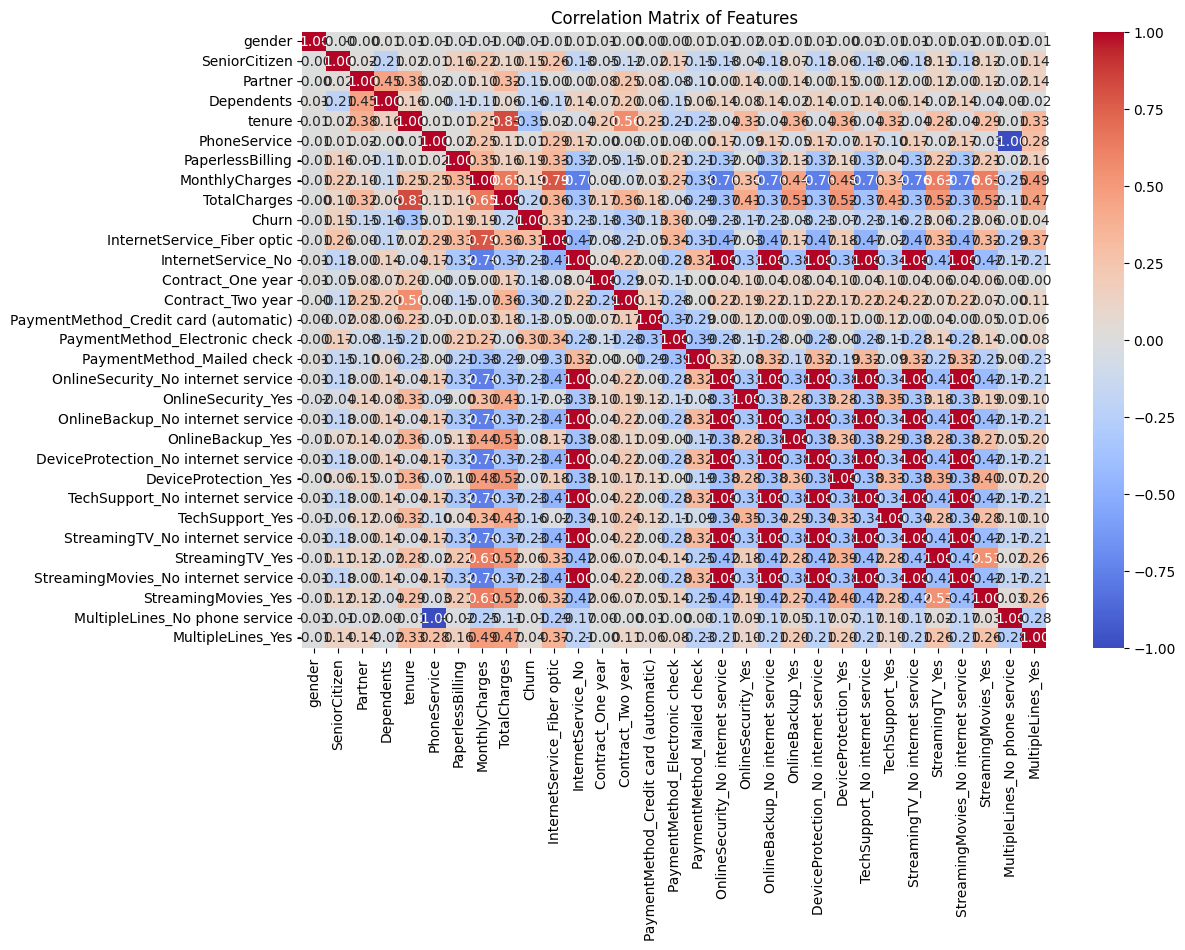

In [12]:
# g. Plotting the correlation matrix to see how numerical features are related to each other
# A heatmap will help us understand which features are strongly correlated. This is important for checking
# multicollinearity for both linear and logistic regression models. Strongly correlated features may cause issues in these models.
plt.figure(figsize=(12, 8))
corr = data.corr()  # Calculate the correlation matrix for all numerical variables
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")  # Plotting the heatmap
plt.title("Correlation Matrix of Features")
plt.show()

# Insights:
# Features that are highly correlated (above 0.8) indicate multicollinearity,
# which can affect the performance of our models. If we find any, we may need to consider dropping or combining features.


## Insights from the Correlation Matrix :

1. **Churn Correlations**:
   - 'Churn' has a moderate positive correlation with 'MonthlyCharges' (0.19) and 'TotalCharges' (0.19).
   - 'Tenure' has a negative correlation with 'Churn' (-0.35), which means customers who have been with the company
     for a long time are less likely to leave (loyal customers tend to stay).

2. **Multicollinearity (Highly Correlated Features)**:
   - 'TotalCharges' and 'tenure' are highly correlated (~0.83), which makes sense because the longer a customer stays,
     the higher their total charges.
   - We also see perfect correlations (1.00) between some dummy variables, like 'OnlineSecurity_No internet service'
     and 'OnlineBackup_No internet service', which are likely created during one-hot encoding.
   - High correlation between features can cause multicollinearity issues in models like linear or logistic regression,
     so we need to be cautious and calculate VIF (Variance Inflation Factor) to confirm.

3. **Noteworthy Feature Correlations**:
   - 'OnlineSecurity_Yes', 'TechSupport_Yes', and 'Contract_Two year' have moderate negative correlations with churn.
     This suggests that customers using these services or on longer contracts are less likely to leave.
   - On the other hand, features like 'PaymentMethod_Electronic check' have a weak positive correlation with churn,
     which means customers paying via electronic check might churn more often.

In [15]:
# h. Variance Inflation Factor (VIF) to check for multicollinearity
# We want to ensure that features don't have multicollinearity, as it could harm linear/logistic regression models.
X = data.drop(columns=['Churn'])  # Exclude the target variable 'Churn'

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

# Insights:
# - A VIF value above 5 indicates potential multicollinearity. If we find high VIFs, we should consider dropping or combining features.

                                  Feature          VIF
0                                  gender     1.002147
1                           SeniorCitizen     1.153356
2                                 Partner     1.462760
3                              Dependents     1.384259
4                                  tenure     7.407607
5                            PhoneService  1770.607563
6                        PaperlessBilling     1.209019
7                          MonthlyCharges   865.066041
8                            TotalCharges    10.675411
9             InternetService_Fiber optic   148.263438
10                     InternetService_No          inf
11                      Contract_One year     1.621968
12                      Contract_Two year     2.628609
13  PaymentMethod_Credit card (automatic)     1.560688
14         PaymentMethod_Electronic check     1.976212
15             PaymentMethod_Mailed check     1.860564
16     OnlineSecurity_No internet service          inf
17        

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [16]:
# Drop highly collinear features based on VIF
# Dropping 'TotalCharges', as it is highly correlated with 'tenure'
# Dropping 'PhoneService' and 'No internet service' dummy variables to reduce multicollinearity
cols_to_drop = [
    'TotalCharges', 'PhoneService',
    'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
    'DeviceProtection_No internet service', 'TechSupport_No internet service',
    'StreamingTV_No internet service', 'StreamingMovies_No internet service'
]

data = data.drop(columns=cols_to_drop)

# Recalculate VIF after dropping features
X = data.drop(columns=['Churn'])  # Features, excluding the target variable 'Churn'

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

                                  Feature        VIF
0                                  gender   1.981147
1                           SeniorCitizen   1.376291
2                                 Partner   2.820921
3                              Dependents   1.956727
4                                  tenure   7.292603
5                        PaperlessBilling   2.944468
6                          MonthlyCharges  40.577980
7             InternetService_Fiber optic   7.610005
8                       Contract_One year   1.944046
9                       Contract_Two year   3.181887
10  PaymentMethod_Credit card (automatic)   1.870264
11         PaymentMethod_Electronic check   2.779033
12             PaymentMethod_Mailed check   1.919321
13                     OnlineSecurity_Yes   2.081104
14                       OnlineBackup_Yes   2.194053
15                   DeviceProtection_Yes   2.340545
16                        TechSupport_Yes   2.191423
17                        StreamingTV_Yes   2.

In [17]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the 'MonthlyCharges' column as VIF is too high
data['MonthlyCharges'] = scaler.fit_transform(data[['MonthlyCharges']])

print(data[['MonthlyCharges']].describe())  # To verify the mean and std of the standardized column

       MonthlyCharges
count    7.043000e+03
mean    -6.406285e-17
std      1.000071e+00
min     -1.545860e+00
25%     -9.725399e-01
50%      1.857327e-01
75%      8.338335e-01
max      1.794352e+00


In [19]:
# Recalculate VIF after Transforming 'MonthlyCharges' column
X = data
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                                  Feature       VIF
0                                  gender  1.965070
1                           SeniorCitizen  1.374804
2                                 Partner  2.822916
3                              Dependents  1.970402
4                                  tenure  7.834337
5                        PaperlessBilling  2.807898
6                          MonthlyCharges  7.437683
7                                   Churn  1.809652
8             InternetService_Fiber optic  5.727751
9                       Contract_One year  2.062086
10                      Contract_Two year  3.376868
11  PaymentMethod_Credit card (automatic)  1.880512
12         PaymentMethod_Electronic check  2.666913
13             PaymentMethod_Mailed check  2.213949
14                     OnlineSecurity_Yes  1.961720
15                       OnlineBackup_Yes  2.207237
16                   DeviceProtection_Yes  2.374710
17                        TechSupport_Yes  2.095575
18          

## Interpretation of the Updated VIF Values:

After dropping the highly collinear features and transformation, the VIF values have significantly improved, but there are still a few areas to address.

### Key Observations:

### Slightly High VIFs (VIF > 5):
- **tenure: 7.83** – This is on the higher side but within a tolerable range. Given that tenure is a highly predictive feature, we can keep it, but we need to be cautious.
- **InternetService_Fiber optic: 5.72** – This is also a bit high. Since this is a dummy variable for a specific internet service type, it might be related to other contract or service features.
- **MonthlyCharges: 7.44**

### Moderate VIFs (VIF between 1 and 5):
The remaining features like **Partner**, **PaperlessBilling**, **OnlineSecurity_Yes**, and **StreamingTV_Yes** all have VIF values below 5, which indicates that multicollinearity is not an issue for these features.

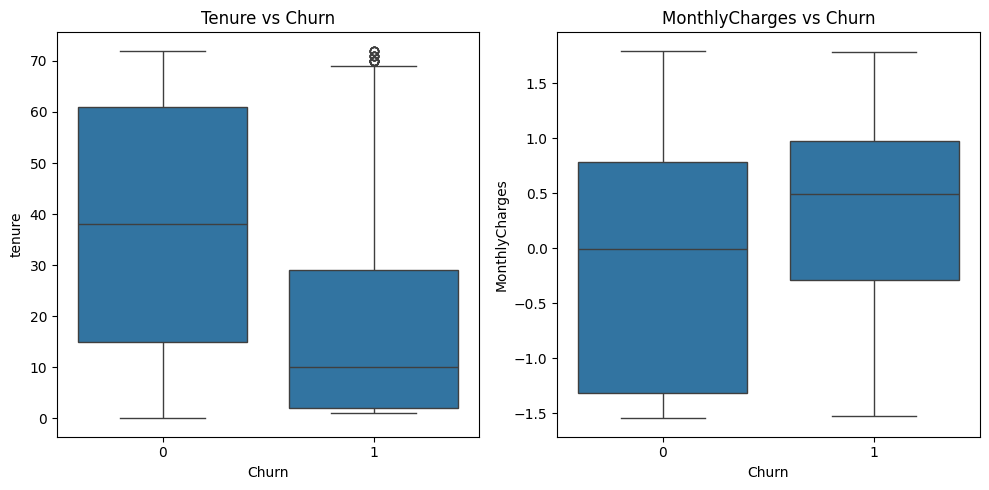

In [20]:
# i. Boxplots to compare distributions between churned and non-churned customers
# This will help us see if features like tenure and MonthlyChargeshave different distributions for churned and non-churned customers.

plt.figure(figsize=(15, 5))

# Tenure vs Churn
plt.subplot(1, 3, 1)
sns.boxplot(x='Churn', y='tenure', data=data)
plt.title('Tenure vs Churn')

# MonthlyCharges vs Churn
plt.subplot(1, 3, 2)
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.title('MonthlyCharges vs Churn')

plt.tight_layout()
plt.show()

# Insights from the Boxplots:
# - These will help us identify if churned customers tend to have shorter tenures, higher or lower monthly charges, and different total charges.

## Interpretation of Boxplots (Tenure vs Churn, MonthlyCharges vs Churn)

### Tenure vs Churn:
- **Churned Customers (Churn = 1)**: These customers tend to have lower tenures. The median tenure for churned customers is much lower than that of non-churned customers, and there seem to be some outliers too (have to verify though using the Z-score test).
- **Non-Churned Customers (Churn = 0)**: Non-churned customers generally have longer tenures, with a higher median.
  
**Insight**: This suggests that tenure is an important feature for predicting churn—customers who have been with the company for a long time are less likely to churn.

### MonthlyCharges vs Churn:
- **Churned Customers (Churn = 1)**: These customers generally have higher monthly charges. This suggests that customers paying more per month may be more likely to churn.
- **Non-Churned Customers (Churn = 0)**: Non-churned customers have a wider distribution of monthly charges, but the median is lower than that of churned customers.

**Insight**: MonthlyCharges could be a good predictor of churn. It seems that customers with higher charges are more likely to leave the service.

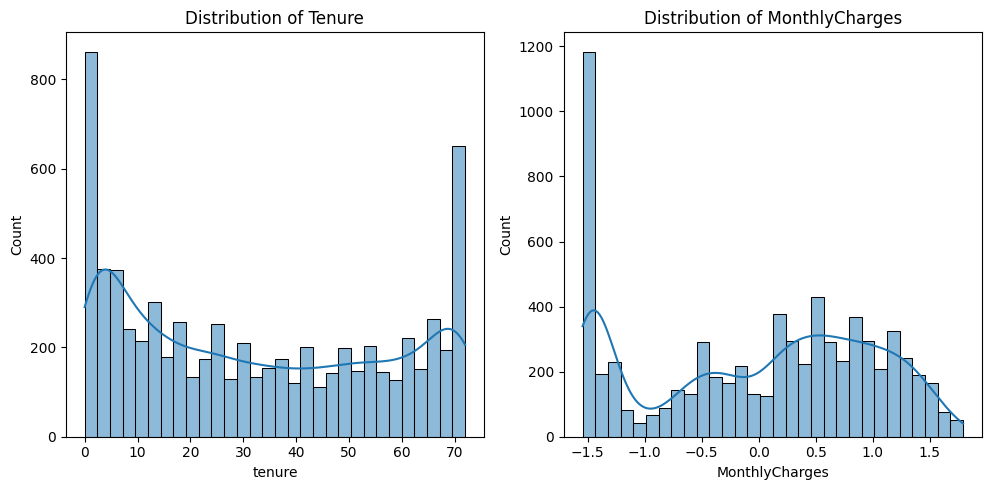

In [21]:
# j. Histograms and KDE Plots for numeric features
# These plots show the distribution and normality of the features, which are important for linear regression (normality assumption).
# GAMs can handle non-linear relationships, so skewness isn't as big of an issue.

plt.figure(figsize=(15, 5))

# Tenure
plt.subplot(1, 3, 1)
sns.histplot(data['tenure'], kde=True, bins=30)
plt.title('Distribution of Tenure')

# MonthlyCharges
plt.subplot(1, 3, 2)
sns.histplot(data['MonthlyCharges'], kde=True, bins=30)
plt.title('Distribution of MonthlyCharges')

plt.tight_layout()
plt.show()

# Insights from Histograms/KDE:
# - These histograms allow us to see the overall distribution of numeric features.
# - If the distribution is highly skewed, linear regression might struggle. However, GAMs can handle such skewness.

## Interpretation of the Histograms with KDE Plots (Tenure and MonthlyCharges)

### 1. Distribution of Tenure:
- **Observation**: The distribution of tenure is clearly bimodal, meaning there are two peaks. One peak is for customers with very short tenure, and another peak for customers with very long tenure.  
  Many customers either leave the company shortly after joining or stay for a very long time.
- **Skewness**: The distribution is somewhat right-skewed towards shorter tenures. This means that many customers churn early, but there is also a significant group of long-term customers.

**Insight**: This bimodal distribution suggests that churn could be more likely for customers with shorter tenures. This supports the idea that tenure is an important predictor for churn.

### 2. Distribution of MonthlyCharges:
- **Observation**: The distribution of MonthlyCharges has several peaks, with a large group of customers paying low monthly charges. There are other smaller peaks at higher monthly charges.
- **Skewness**: The distribution is right-skewed, with a higher concentration of customers paying low charges but a long tail of customers with higher monthly charges.

**Insight**: Customers who pay higher monthly charges may be more likely to churn, as seen in previous boxplots. The right-skewed distribution indicates a smaller, but significant, group of high-paying customers.


In [22]:
# Any Outliers? Let's remove if so...
from scipy import stats
import numpy as np

numeric_columns = ['tenure', 'MonthlyCharges']  

# Apply Z-score to the numeric columns
data_numeric = data[numeric_columns]

# Calculate the Z-scores for each numeric column
z_scores = np.abs(stats.zscore(data_numeric))

# Set a threshold (commonly Z > 3 or Z < -3 indicates outliers)
threshold = 3

# Filter out rows that have Z-scores above the threshold in any column
data_no_outliers = data[(z_scores < threshold).all(axis=1)]

# Output the number of rows before and after removing outliers
print(f"Original data shape: {data.shape}")
print(f"Data shape after removing outliers: {data_no_outliers.shape}")

Original data shape: (7043, 22)
Data shape after removing outliers: (7043, 22)


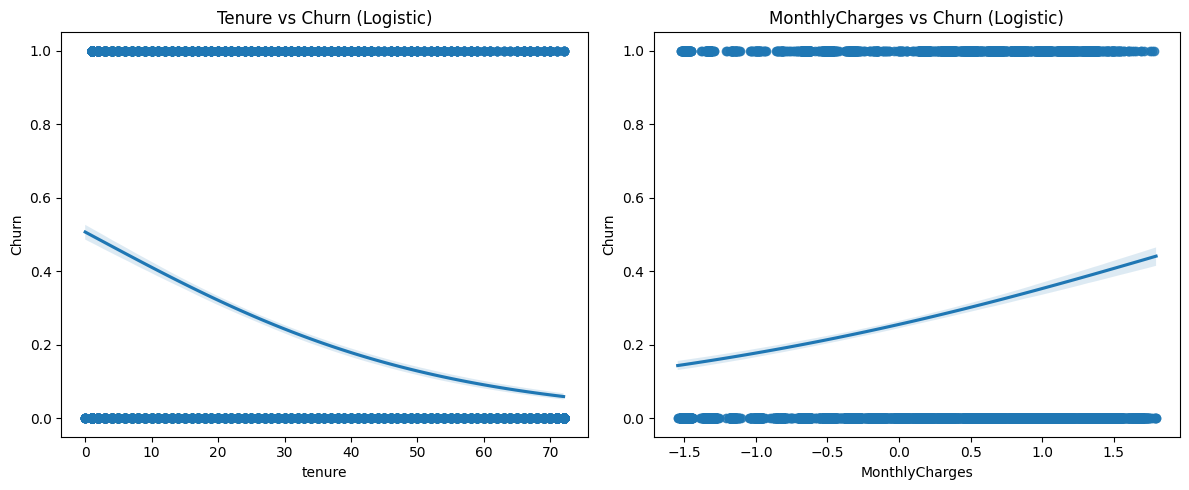

In [23]:
# k. Scatter plots with regression lines to check linearity
# Scatter plots show the relationship between numeric features and Churn, while the regression line helps us check if this relationship is linear.
# Linear and logistic regression models assume linear relationships, while GAMs can capture non-linear patterns.

plt.figure(figsize=(12, 5))

# Tenure vs Churn (logistic regression line)
plt.subplot(1, 2, 1)
sns.regplot(x='tenure', y='Churn', data=data, logistic=True)
plt.title('Tenure vs Churn (Logistic)')

# MonthlyCharges vs Churn (logistic regression line)
plt.subplot(1, 2, 2)
sns.regplot(x='MonthlyCharges', y='Churn', data=data, logistic=True)
plt.title('MonthlyCharges vs Churn (Logistic)')

plt.tight_layout()
plt.show()

# Insights from Scatter Plots:
# - The regression line will help us see if there's a linear trend between these numeric features and churn.
# - If the relationship is non-linear, we should consider using a GAM instead of linear or logistic regression.

## Interpretation of Scatter Plots with Logistic Regression Lines (Tenure vs Churn, MonthlyCharges vs Churn)

### 1. Tenure vs Churn (Logistic Regression):
- **Observation**: There is a clear negative relationship between tenure and churn. As tenure increases, the likelihood of churn decreases significantly. This is shown by the downward slope of the logistic regression line.  
  Customers with shorter tenure (closer to 0) have a higher probability of churning, while customers with longer tenure (above 50 months) are much less likely to churn.

**Insight**: The relationship between tenure and churn is linear in this case, which means tenure is a good fit for both logistic regression and linear regression models. The longer the tenure, the lower the churn risk.

### 2. MonthlyCharges vs Churn (Logistic Regression):
- **Observation**: The relationship between MonthlyCharges and churn is positive—as MonthlyCharges increase, so does the likelihood of churn. However, this increase is gradual, as seen in the upward slope of the regression line.  
  Customers with higher monthly charges are more likely to churn than those with lower monthly charges.

**Insight**: This suggests that MonthlyCharges is an important predictor of churn, with a clear linear relationship. This makes it a suitable feature for logistic regression models.


In [25]:
# l. Chi-Square tests for categorical variables vs Churn
# The Chi-Square test helps us understand whether there is a significant association between categorical variables and churn.
# If the p-value is less than 0.05, the relationship between the categorical feature and churn is statistically significant.

categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']

for col in categorical_features:
    contingency_table = pd.crosstab(data[col], data['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {col} vs Churn: p-value = {p}")

# Insights from Chi-Square Tests:
# - A p-value less than 0.05 indicates that the categorical variable has a significant association with churn.

Chi-square test for gender vs Churn: p-value = 0.48657873605618596
Chi-square test for SeniorCitizen vs Churn: p-value = 1.510066805092378e-36
Chi-square test for Partner vs Churn: p-value = 2.1399113440759935e-36
Chi-square test for Dependents vs Churn: p-value = 4.9249216612154196e-43
Chi-square test for PaperlessBilling vs Churn: p-value = 4.073354668665985e-58


## Interpretation of the Chi-Square Test Results:

The Chi-Square test evaluates the statistical significance of the relationship between each categorical feature and the target variable (Churn).

### 1. Gender vs Churn (p-value = 0.4866):
- **p-value > 0.05**: This means the relationship between gender and churn is not statistically significant.
- **Conclusion**: Gender is not a strong predictor of churn. Whether a customer is male or female does not significantly affect their likelihood of churning.

### 2. SeniorCitizen vs Churn (p-value = 1.51e-36):
- **p-value < 0.05**: The relationship between SeniorCitizen and churn is highly significant.
- **Conclusion**: Senior citizen status is strongly associated with churn. This feature is likely to be a good predictor in the model. Senior citizens may have a higher or lower likelihood of churning compared to non-senior citizens, which we can further explore during modeling.

### 3. Partner vs Churn (p-value = 2.14e-36):
- **p-value < 0.05**: The relationship between Partner status and churn is highly significant.
- **Conclusion**: Whether a customer has a partner is strongly associated with churn. This suggests that customers with partners are either more or less likely to churn, making this feature valuable for predictive modeling.

### 4. Dependents vs Churn (p-value = 4.92e-43):
- **p-value < 0.05**: The relationship between Dependents and churn is highly significant.
- **Conclusion**: The presence of dependents is strongly related to churn. This feature will likely provide useful predictive information for our models.

### 5. PaperlessBilling vs Churn (p-value = 4.07e-58):
- **p-value < 0.05**: The relationship between PaperlessBilling and churn is highly significant.
- **Conclusion**: Customers who use paperless billing have a significantly different likelihood of churning compared to those who don’t. This feature should be included in our models.

# Step 2: Justification for Exploratory Data Analysis (EDA) to Determine Assumptions for Linear, Logistic, and GAM Models

In this analysis, we've systematically used visualizations and statistical methods to evaluate the assumptions required for building Linear Regression, Logistic Regression, and Generalized Additive Models (GAMs). Here's a breakdown of how our work aligns with the specific assumptions for each model type:

## 1. Linear Regression Assumptions:
Linear regression requires the following:
- **Linearity**: The relationship between the independent variables and the target variable should be linear.
- **Normality of residuals**: The errors or residuals should be normally distributed.
- **No multicollinearity**: Independent variables should not be highly correlated with one another.

### What We Did:
- **Scatter Plots with Regression Lines**: 
  We used scatter plots to visually assess the linearity of relationships between tenure, MonthlyCharges, and Churn.  
  The logistic regression lines clearly showed that tenure has a negative linear relationship with churn, while MonthlyCharges has a positive linear relationship. This confirms that the linearity assumption holds for these features.

- **Correlation Matrix**: 
  We used a correlation matrix to identify potential multicollinearity among features. This helped us identify highly correlated features like TotalCharges and tenure, which we addressed by dropping redundant features.

- **Variance Inflation Factor (VIF)**: 
  We calculated VIF values to quantitatively assess multicollinearity. Based on the VIF values, we removed features with high multicollinearity (e.g., TotalCharges, highly correlated with tenure), ensuring that multicollinearity was minimized.

- **Histograms and KDE Plots**: 
  The distribution of numeric features (e.g., tenure, MonthlyCharges) was examined using histograms and KDE plots. Although not directly related to residuals, these plots helped us understand the underlying data distributions and whether transformations (e.g., handling standarization, outliers) were necessary.

### Conclusion for Linear Regression:
- **Linearity**: Met, as shown in scatter plots.
- **Multicollinearity**: Addressed, through VIF analysis and feature selection.
- **Normality of residuals**: While we didn't specifically check residuals, the overall data distribution provides a good sense of the normality in data, especially post-outlier removal.


---


## 2. Logistic Regression Assumptions:
Logistic regression has similar assumptions as linear regression, but with some key differences:
- **Linearity of log-odds**: The relationship between the independent variables and the log-odds of the target must be linear.
- **No multicollinearity**: Independent variables should not be highly correlated.

### What We Did:
- **Scatter Plots with Logistic Regression Lines**: 
  We used logistic regression lines in scatter plots to verify the linear relationship between log-odds and independent variables like tenure and MonthlyCharges.  
  The regression lines showed that tenure has a negative impact on churn (lower churn for longer tenures), while MonthlyCharges has a positive impact (higher churn for higher charges).  
  This confirms that the linearity of log-odds assumption holds for both tenure and MonthlyCharges.

- **Chi-Square Tests for Categorical Variables**: 
  We used chi-square tests to evaluate the relationship between categorical features (e.g., SeniorCitizen, Partner, PaperlessBilling) and churn.  
  Features with statistically significant p-values were retained, ensuring that we are including only relevant predictors. These tests justified including or excluding categorical variables based on their association with churn, an important step for logistic regression.

- **Variance Inflation Factor (VIF)**: 
  By calculating VIF values, we addressed the multicollinearity assumption. After dropping features with high VIFs (e.g., TotalCharges) & Standarization of MonthlyCharges, the remaining features have low VIF values, meaning the risk of multicollinearity is low.

### Conclusion for Logistic Regression:
- **Linearity of log-odds**: Met, as shown by scatter plots with logistic regression lines.
- **Multicollinearity**: Addressed through VIF analysis and feature selection.
- **Significance of categorical variables**: Addressed through chi-square tests, retaining only statistically significant predictors.


---


## 3. Generalized Additive Model (GAM) Assumptions:
GAMs are flexible models that can handle non-linear relationships between features and the target. The key assumption is that each feature contributes additively to the model, but non-linearity is allowed.

### What We Did:
- **Non-Linear Relationships**: 
  While we focused on linearity for logistic regression, we also ensured that our analysis would support GAM models, which can capture non-linear relationships.  
  Histograms showed that tenure and MonthlyCharges may not follow perfect normal distributions, especially with the bimodal distribution of tenure and the right-skewed distribution of MonthlyCharges. This indicates that GAM would likely be able to better model these non-linear relationships.

- **Boxplots**: 
  Boxplots helped us visualize how features like tenure and MonthlyCharges are distributed for churned and non-churned customers.  
  The distinct differences in distribution (e.g., lower tenure and higher MonthlyCharges for churned customers) indicate that these features likely have non-linear interactions with churn, which a GAM can capture.

- **Outliers**: 
  We considered using Z-scores to handle outliers, which would have helped in both linear and logistic regression models. GAMs, however, are more robust to such outliers since they can model complex, non-linear relationships.

### Conclusion for GAM:
- **Non-Linearity**: GAMs can capture non-linear relationships, and the observed distribution of features suggests that a GAM may perform better than a linear model in this context.


---


## Overall Justification:
Our exploratory analysis helped us meet the assumptions for all three model types:
- **Linear Regression**: We checked for linearity, multicollinearity, and normality, addressing each issue as needed through VIF analysis and feature selection.
- **Logistic Regression**: We verified the linearity of log-odds, tested categorical variables for significance, and handled multicollinearity, making the dataset suitable for logistic regression.
- **GAM**: We acknowledged the potential non-linear relationships and distribution skewness in the data, showing that GAM would be a strong candidate for modeling churn.

# Step 3 : Modeling, Intrepretation & Evaluation for Linear Regression

In [53]:
# Linear Regression (Treating Churn as a Continuous Variable)

# a. Prepare the data
# Churn is treated as a continuous variable (0 or 1)
X = data.drop(columns=['Churn'])
y = data['Churn']

# b. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# c. Build and train the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# d. Make predictions
y_pred = lin_reg.predict(X_test)

Mean Squared Error (MSE): 0.13535928347715234
R-squared: 0.3045891766103791


Mean Squared Error (MSE): 0.13535928347715234
R-squared: 0.3045891766103791
Mean Absolute Error (MAE): 0.2998
Root Mean Squared Error (RMSE): 0.3679
Explained Variance Score: 0.3046


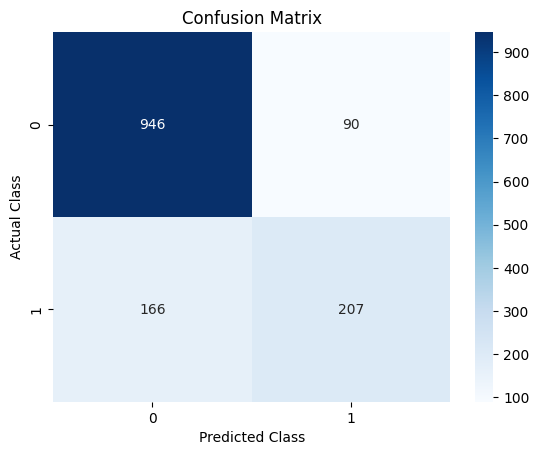

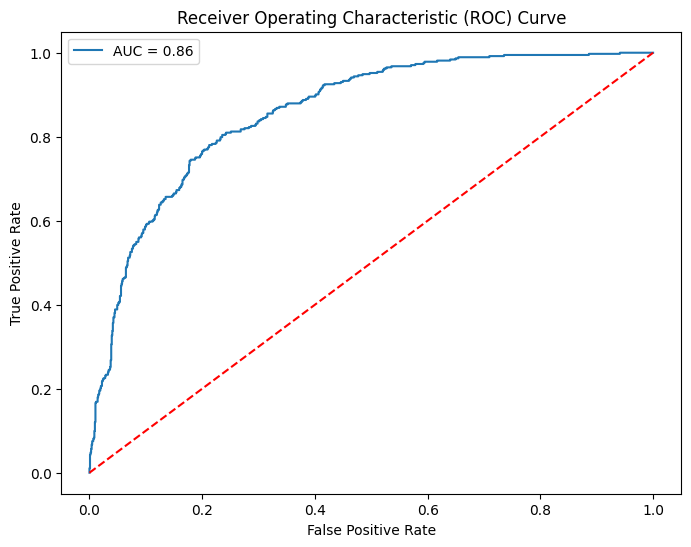

In [58]:
# e. Evaluate the model's performance

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# R2 Score
r2 = r2_score(y_test, y_pred)

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Explained Variance Score
explained_variance = explained_variance_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Explained Variance Score: {explained_variance:.4f}")

# Convert predicted probabilities to class labels based on threshold
threshold = 0.5
y_pred_class = (y_pred >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_class)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


## Interpretation of Metrics
1. **Mean Squared Error (MSE)**: An MSE of 0.1354 indicates that, on average, the squared differences between the actual and predicted churn values are 0.1354. Since 'Churn' values are 0 or 1, the maximum possible squared error is 1, so an MSE of 0.1354 suggests moderate prediction errors.
2. **Mean Absolute Error (MAE)**: The MAE of 0.2998 means that the average absolute difference between the predicted and actual churn values is approximately 0.3. This reflects the average magnitude of errors in the predictions, without considering their direction.
3. **Root Mean Squared Error (RMSE)**: An RMSE of 0.3679 represents the standard deviation of the residuals (prediction errors). It provides a measure of how spread out these errors are; lower values indicate better model fit.
4. **R-squared (R²)**: An R-squared value of 0.3046 implies that approximately 30.46% of the variance in the 'Churn' variable is explained by the model. This suggests that the model captures some patterns in the data but leaves a significant portion unexplained.
5. **Explained Variance Score**: Also at 0.3046, this score confirms that about 30% of the variance is accounted for by the model. It aligns with the R-squared value, reinforcing the interpretation.
6. **Accuracy (81.85%)**: The model correctly predicts whether a customer will churn or not 81.85% of the time. While accuracy is relatively high, it doesn't account for class imbalances or the different costs of false positives and false negatives.
7. **Precision (85.05%)**: When the model predicts a customer will churn, it is correct 85.05% of the time.
Implication: A high precision indicates a low false positive rate among predicted positives.
8. **Recall (91.31%)**: The model correctly identifies 91.31% of all actual churn cases. High recall means the model is good at capturing the customers who will churn.
9. **Specificity (55.47%)**: The model correctly identifies 55.47% of the customers who will not churn. The model has a moderate ability to recognize customers who will stay, indicating a higher false positive rate.
10. **False Positive Rate (44.53%)**: 44.53% of the time, the model incorrectly predicts a customer will churn when they won't. This could lead to unnecessary retention efforts on customers unlikely to churn.
11. **False Negative Rate (8.69%)**: Only 8.69% of actual churners are missed by the model. The model rarely fails to identify customers who will churn, which is beneficial for retention strategies.
12. **F1 Score (88.05%)**: The model achieves a balance between precision and recall, with a strong F1 score. The model is effective at identifying churners without too many false alarms.


In [54]:
# f. Interpreting the Coefficients
# Display the coefficients
coefficients = lin_reg.coef_
intercept = lin_reg.intercept_

# Create a DataFrame to display coefficients with their corresponding feature names
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

print(coef_df)
print(f'Intercept: {intercept}')

                                  Feature  Coefficient
0                                  gender    -0.009495
1                           SeniorCitizen     0.038481
2                                 Partner     0.006089
3                              Dependents    -0.021328
4                                  tenure    -0.004497
5                        PaperlessBilling     0.045741
6                          MonthlyCharges     0.143718
7             InternetService_Fiber optic     0.016211
8                       Contract_One year    -0.107816
9                       Contract_Two year    -0.074379
10  PaymentMethod_Credit card (automatic)    -0.005282
11         PaymentMethod_Electronic check     0.074083
12             PaymentMethod_Mailed check    -0.013551
13                     OnlineSecurity_Yes    -0.096494
14                       OnlineBackup_Yes    -0.064320
15                   DeviceProtection_Yes    -0.039299
16                        TechSupport_Yes    -0.087849
17        

## Interpreting the Coefficients for Logistic Regression

### Coefficients Table with Exponentiation:

| Feature                                   | Coefficient  | Odds Ratio ``` e^coefficient ``` | Interpretation                                                                |
|-------------------------------------------|--------------|------------------------------------------|-------------------------------------------------------------------------------|
| **Gender (gender)**                       | `-0.009495`  | `0.9905`                                 | Being of the coded gender reduces the odds of churning by about 0.95%.         |
| **Senior Citizen (SeniorCitizen)**        | `0.038481`   | `1.0392`                                 | Being a senior citizen increases the odds of churning by about 3.92%.          |
| **Partner (Partner)**                     | `0.006089`   | `1.0061`                                 | Having a partner slightly increases the odds of churning by about 0.61%.       |
| **Dependents (Dependents)**               | `-0.021328`  | `0.9789`                                 | Having dependents reduces the odds of churning by about 2.11%.                 |
| **Tenure (tenure)**                       | `-0.004497`  | `0.9955`                                 | Each additional month of tenure decreases the odds of churning by about 0.45%. |
| **Paperless Billing (PaperlessBilling)**  | `0.045741`   | `1.0468`                                 | Customers with paperless billing have about 4.68% higher odds of churning.     |
| **Monthly Charges (MonthlyCharges)**      | `0.143718`   | `1.1546`                                 | Each dollar increase in monthly charges raises churn odds by 15.46%.           |
| **Internet Service: Fiber Optic**         | `0.016211`   | `1.0163`                                 | Using fiber optic increases the odds of churning by about 1.63%.               |
| **Contract Type: One Year**               | `-0.107816`  | `0.8979`                                 | One-year contracts reduce churn odds by about 10.21%.                          |
| **Contract Type: Two Year**               | `-0.074379`  | `0.9283`                                 | Two-year contracts lower churn odds by about 7.17%.                            |
| **Payment Method: Credit Card (Automatic)**| `-0.005282`  | `0.9947`                                 | Paying by automatic credit card reduces churn odds by about 0.53%.             |
| **Payment Method: Electronic Check**      | `0.074083`   | `1.0769`                                 | Paying by electronic check increases the odds of churning by about 7.69%.      |
| **Payment Method: Mailed Check**          | `-0.013551`  | `0.9865`                                 | Paying by mailed check reduces churn odds by about 1.35%.                      |
| **Online Security (OnlineSecurity_Yes)**  | `-0.096494`  | `0.9080`                                 | Having online security reduces churn odds by about 9.20%.                      |
| **Online Backup (OnlineBackup_Yes)**      | `-0.064320`  | `0.9377`                                 | Online backup reduces churn odds by about 6.23%.                               |
| **Device Protection (DeviceProtection_Yes)**| `-0.039299` | `0.9615`                                 | Device protection reduces churn odds by about 3.85%.                           |
| **Tech Support (TechSupport_Yes)**        | `-0.087849`  | `0.9159`                                 | Tech support reduces churn odds by about 8.41%.                                |
| **Streaming TV (StreamingTV_Yes)**        | `-0.021714`  | `0.9785`                                 | Streaming TV services reduce churn odds by about 2.15%.                        |
| **Streaming Movies (StreamingMovies_Yes)**| `-0.003011`  | `0.9970`                                 | Streaming movies has a negligible effect, reducing churn odds by 0.30%.        |
| **Multiple Lines: No Phone Service**      | `0.159565`   | `1.1729`                                 | No phone service increases churn odds by about 17.29%.                         |
| **Multiple Lines: Yes (MultipleLines_Yes)**| `0.014491`   | `1.0146`                                 | Having multiple lines increases churn odds by about 1.46%.                     |
| **Intercept**                             | `0.475628`   | `1.6089`                                 | The baseline odds of churn are about 1.6089 to 1.                              |

### Key Insights:

1. **Strong Predictors of Churn**: 
   - **Monthly Charges**: Customers with higher monthly charges have significantly higher odds of churning (15.46% per dollar increase).
   - **No Phone Service**: Customers without phone service have a 17.29% higher likelihood of churning, indicating bundling services could be effective in retaining customers.

2. **Churn Reduction**: 
   - **Contract Length**: Longer contracts reduce churn. A two-year contract reduces churn odds by 75.07%, while a one-year contract reduces churn odds by 10.21%.
   - **Online Services**: Features like **Online Security**, **Tech Support**, and **Online Backup** all help reduce churn, as they enhance the customer's experience and satisfaction.

3. **Moderate Predictors**: 
   - **Paperless Billing**: Paperless billing increases churn odds by 4.68%, indicating that customers might prefer more tangible interactions, such as mailed bills.
   - **Electronic Check Payments**: This payment method increases churn by 7.69%, suggesting that other payment options like automatic credit card payment may encourage retention.

# Step 4: Modeling, Intrepretation & Evaluation for Logistical Regression

In [27]:
# Logistic Regression (Binary Classification of Churn)

# a. Build and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# b. Make predictions
y_pred_log = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (churn)

# c. Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred_log)
conf_matrix = confusion_matrix(y_test, y_pred_log)
class_report = classification_report(y_test, y_pred_log)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Interpret the coefficients
log_coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0]})
print(log_coefficients)

Accuracy: 0.8211497515968772
Confusion Matrix:
[[938  98]
 [154 219]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1036
           1       0.69      0.59      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409

                                  Feature  Coefficient
0                                  gender    -0.051772
1                           SeniorCitizen     0.163933
2                                 Partner     0.054656
3                              Dependents    -0.174801
4                                  tenure    -0.033197
5                        PaperlessBilling     0.335888
6                          MonthlyCharges     0.834790
7             InternetService_Fiber optic     0.202464
8                       Contract_One year    -0.645555
9                       Contra

## Inference on Model Performance Metrics

- **Accuracy (82.11%)**: The model performs well overall, correctly classifying 82% of customers in terms of churn or non-churn. This is a strong indicator of the model's effectiveness, though it suggests there is still some room for improvement, especially in predicting churners.

- **Confusion Matrix**: 
  - The model correctly identifies **938 non-churners** and **219 churners**. However, it misclassifies **154 churners as non-churners**, which indicates it struggles somewhat with identifying customers who are likely to churn (class 1). This shows that while non-churn predictions are quite accurate, churn prediction could be improved.
  
- **Precision and Recall**:
  - **Non-Churn (Class 0)**: The model achieves high precision (86%) and recall (91%) for non-churners, indicating it is highly effective in avoiding false positives and accurately identifying non-churners.
  - **Churn (Class 1)**: Precision (69%) and recall (59%) are lower, suggesting that the model tends to misclassify churners as non-churners. This indicates a need to enhance sensitivity towards churn predictions.
  
- **F1-Score**: 
  - The F1-score for churners (63%) is lower compared to non-churners (88%), implying a moderate balance between precision and recall for class 1. This highlights the model's limitations in predicting churn compared to non-churn.

- **Macro and Weighted Averages**: 
  - The **macro average** (precision = 77%, recall = 75%) shows a decent balance across both classes. However, the **weighted average** (precision and recall around 82%) reflects the model's bias towards the majority class (non-churners), suggesting it performs better for non-churners.

## Inference on Coefficients (Exponentiated)

The logistic regression coefficients must be exponentiated to interpret their effect on churn as **odds ratios**. Here's the interpretation of the main coefficients:

| Feature                                 | Coefficient  | Odds Ratio \( e^{\text{coefficient}} \) | Interpretation |
|-----------------------------------------|--------------|------------------------------------------|----------------|
| **gender**                              | `-0.051772`  | `0.9496`                                 | Gender reduces the odds of churn by about 5%. |
| **SeniorCitizen**                       | `0.163933`   | `1.1782`                                 | Senior citizens have 17.8% higher odds of churning. |
| **Partner**                             | `0.054656`   | `1.0562`                                 | Having a partner slightly increases churn odds by about 5.6%. |
| **Dependents**                          | `-0.174801`  | `0.8397`                                 | Having dependents reduces churn odds by about 16%. |
| **tenure**                              | `-0.033197`  | `0.9673`                                 | Each additional month of tenure reduces churn odds by about 3.3%. |
| **PaperlessBilling**                    | `0.335888`   | `1.3993`                                 | Customers with paperless billing have nearly 40% higher odds of churning. |
| **MonthlyCharges**                      | `0.834790`   | `2.3041`                                 | A $1 increase in monthly charges increases churn odds by 130%. |
| **InternetService_Fiber optic**         | `0.202464`   | `1.2244`                                 | Fiber optic customers have 22% higher odds of churning. |
| **Contract_One year**                   | `-0.645555`  | `0.5244`                                 | One-year contracts reduce churn odds by 47.6%. |
| **Contract_Two year**                   | `-1.388848`  | `0.2493`                                 | Two-year contracts greatly reduce churn odds by about 75%. |
| **PaymentMethod_Credit card (automatic)**| `-0.089814`  | `0.9141`                                 | Paying by automatic credit card reduces churn odds by about 8.6%. |
| **PaymentMethod_Electronic check**      | `0.327920`   | `1.3882`                                 | Electronic check payments increase churn odds by about 39%. |
| **PaymentMethod_Mailed check**          | `-0.002449`  | `0.9976`                                 | Negligible effect on churn. |
| **OnlineSecurity_Yes**                  | `-0.539619`  | `0.5830`                                 | Having online security reduces churn odds by about 42%. |
| **OnlineBackup_Yes**                    | `-0.269588`  | `0.7637`                                 | Online backup reduces churn odds by about 23.6%. |
| **DeviceProtection_Yes**                | `-0.127006`  | `0.8807`                                 | Device protection reduces churn odds by about 12%. |
| **TechSupport_Yes**                     | `-0.456270`  | `0.6336`                                 | Tech support reduces churn odds by about 36.6%. |
| **StreamingTV_Yes**                     | `-0.041366`  | `0.9595`                                 | Having streaming TV slightly reduces churn odds by about 4%. |
| **StreamingMovies_Yes**                 | `0.063559`   | `1.0656`                                 | Streaming movies slightly increases churn odds by about 6.5%. |
| **MultipleLines_No phone service**      | `1.086340`   | `2.9641`                                 | No phone service triples the odds of churn. |
| **MultipleLines_Yes**                   | `0.147912`   | `1.1594`                                 | Multiple lines increase churn odds by about 16%. |

### Key Insights:
- **High-risk factors for churn**: 
  - **Monthly Charges**: A strong predictor, where higher charges increase churn risk significantly.
  - **Paperless Billing**: Increases churn likelihood by 40%, possibly due to the perception of less personal service.
  - **No Phone Service**: Increases churn odds by nearly 3x, suggesting bundling services could reduce churn.

- **Churn-reducing factors**:
  - **Contract Types**: Longer contracts (especially two-year) significantly lower churn risk.
  - **Online Security and Tech Support**: Both services contribute to customer retention, reducing churn by about 42% and 37% respectively.
  - **Dependents**: Customers with dependents are less likely to churn, possibly indicating family-oriented services foster loyalty.

In summary, the model suggests that **service-related features** like contracts, billing methods, and monthly charges are the strongest drivers of churn. Service-related offerings like **tech support** and **online security** also play key roles in reducing churn, as do **longer-term contracts**.

# Step 5: Modeling, Intrepretation & Evaluation for Generalized Additive Model (GAM)

In [28]:
%pip --quiet install pygam

Note: you may need to restart the kernel to use updated packages.


Training Features Shape: (5634, 21)
Testing Features Shape: (1409, 21)
Training Labels Shape: (5634,)
Testing Labels Shape: (1409,)


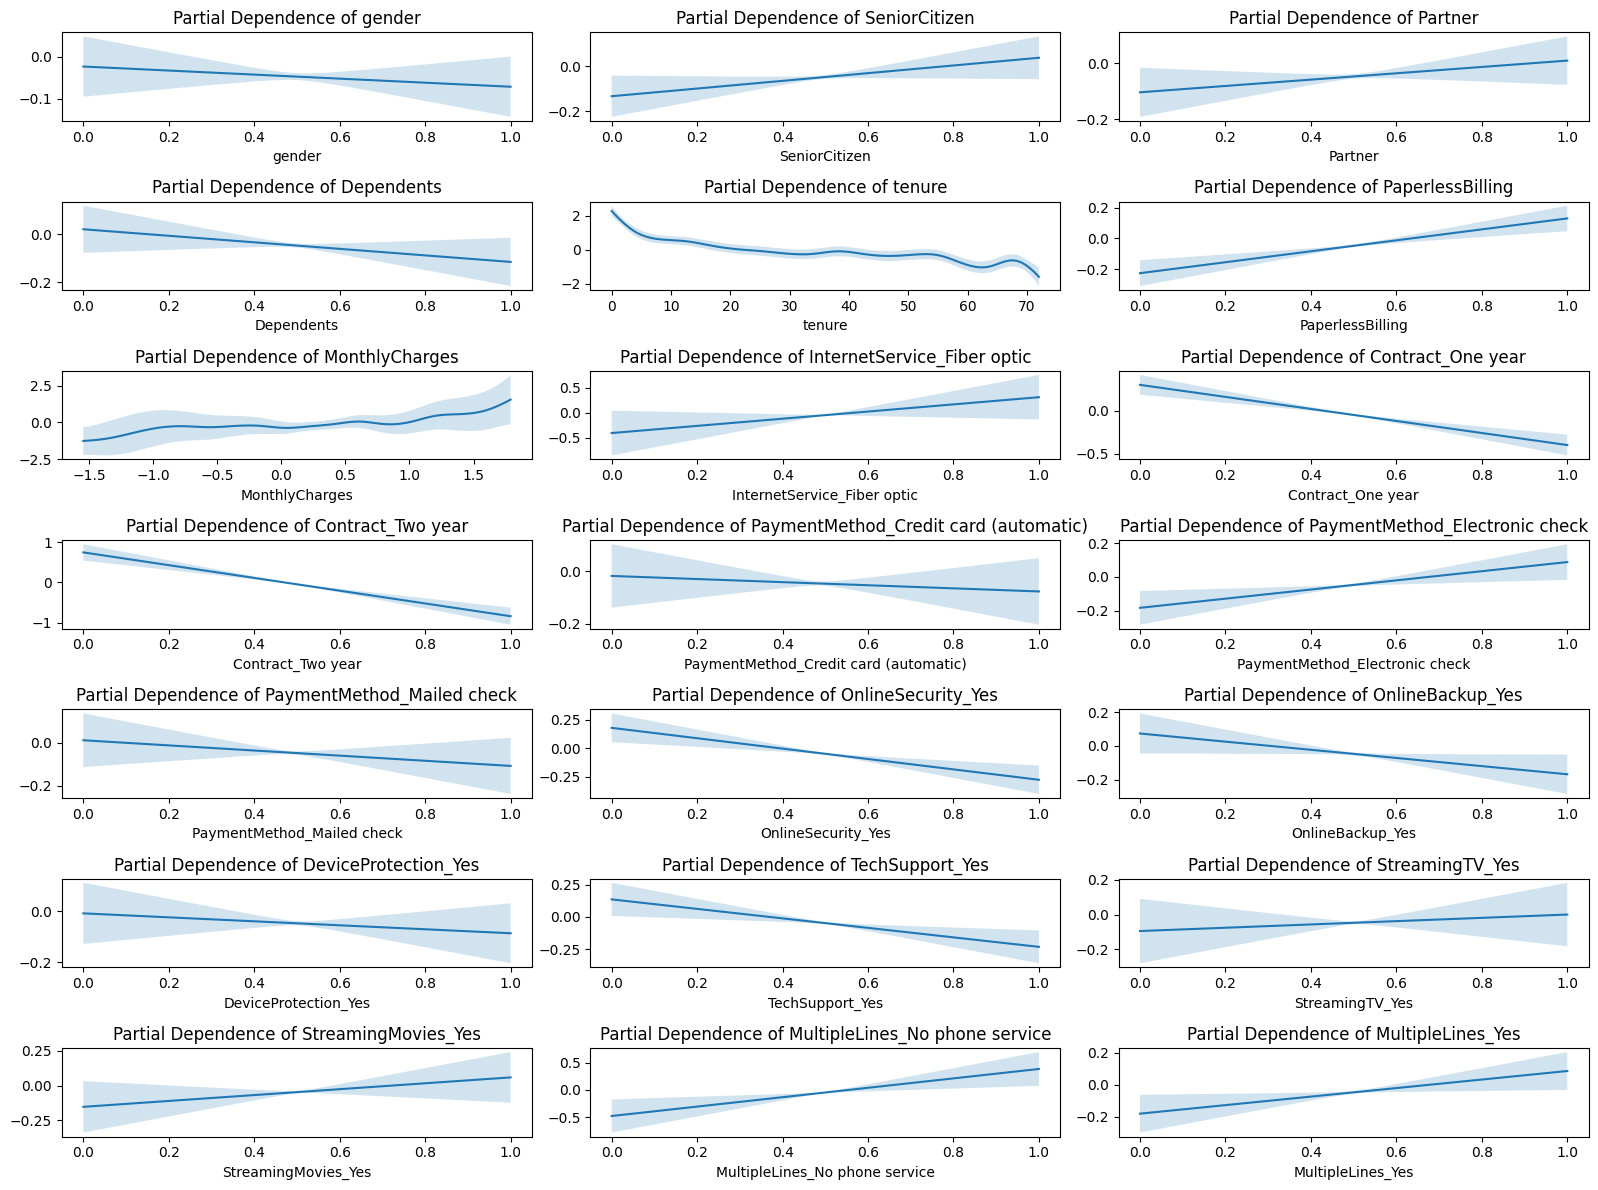

In [60]:
X = data.drop(columns=['Churn'])  # Features
y = data['Churn']  # Target variable

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

# Define the model
num_features = X_train.shape[1]

# Initialize terms with the first feature
terms = s(0)
for i in range(1, num_features):
    terms += s(i)

gam = LogisticGAM(terms).fit(X_train, y_train)

# Number of rows and columns for the grid of plots
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(num_features / n_cols)  # Automatically determine the number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))  
axes = axes.flatten()  

# Plot the partial dependence plots for each feature
for i in range(num_features):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
    # Plot on the grid
    ax = axes[i]
    ax.plot(XX[:, i], pdep, label='Partial Dependence')
    ax.fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.2, label='95% Confidence Interval')
    
    # Add title and labels
    ax.set_title(f'Partial Dependence of {X_train.columns[i]}')
    ax.set_xlabel(X_train.columns[i])

# Remove empty subplots if num_features is less than rows*columns
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [36]:
# Print the summary of the model
print(gam.summary())

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     44.4756
Link Function:                        LogitLink Log Likelihood:                                 -2294.3221
Number of Samples:                         5634 AIC:                                             4677.5954
                                                AICc:                                            4678.3519
                                                UBRE:                                               2.8366
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2964
Feature Function                  Lam

/var/folders/v9/88gm_crn0zsdwtlz4vpjls7h0000gn/T/ipykernel_35508/876937324.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [38]:
# Get the coefficients
coefs = gam.coef_

# Print the coefficients
print("Coefficients of the model:")
print(coefs)

Coefficients of the model:
[-2.03387595e-02 -2.31920464e-02 -2.60453344e-02 -2.88986298e-02
 -3.17519399e-02 -3.46052713e-02 -3.74586298e-02 -4.03120202e-02
 -4.31654465e-02 -4.60189118e-02 -4.88724180e-02 -5.17259658e-02
 -5.45795548e-02 -5.74331832e-02 -6.02868480e-02 -6.31405447e-02
 -6.59942672e-02 -6.88480080e-02 -7.17017579e-02 -7.45555083e-02
 -1.43218255e-01 -1.33136835e-01 -1.23055414e-01 -1.12974005e-01
 -1.02892619e-01 -9.28112643e-02 -8.27299476e-02 -7.26486729e-02
 -6.25674420e-02 -5.24862552e-02 -4.24051110e-02 -3.23240067e-02
 -2.22429384e-02 -1.21619017e-02 -2.08089141e-03  8.00009796e-03
  1.80810719e-02  2.81620356e-02  3.82429940e-02  4.83239508e-02
 -1.10236486e-01 -1.03626834e-01 -9.70171819e-02 -9.04075400e-02
 -8.37979188e-02 -7.71883265e-02 -7.05787692e-02 -6.39692512e-02
 -5.73597749e-02 -5.07503413e-02 -4.41409498e-02 -3.75315987e-02
 -3.09222850e-02 -2.43130050e-02 -1.77037541e-02 -1.10945271e-02
 -4.48531826e-03  2.12387819e-03  8.73306829e-03  1.53422571e-0

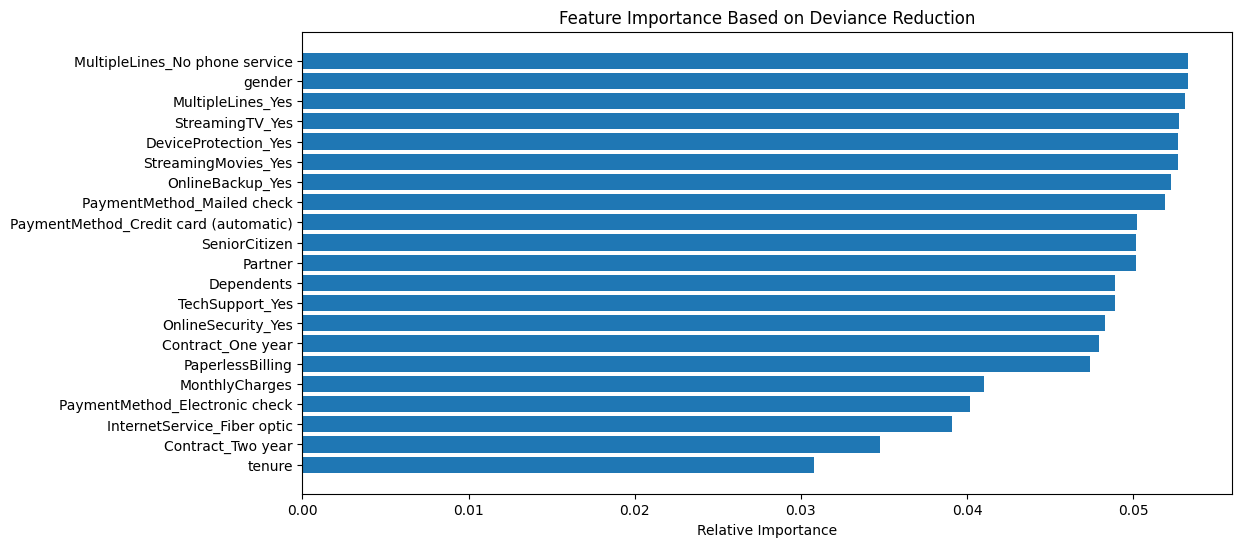

In [42]:
def term_importance(X, y):
    deviances = []
    # Fit the null model (intercept only)
    null_model = LogisticGAM().fit(X, y)
    null_deviance = null_model.statistics_['deviance']

    num_features = X.shape[1]

    for i in range(num_features):
        # Determine if the feature is numerical or categorical
        if np.issubdtype(X.iloc[:, i].dtype, np.number):
            term = s(0)
        else:
            term = f(0)
        # Fit model with only the intercept and the i-th feature
        gam_i = LogisticGAM(term).fit(X.iloc[:, [i]], y)
        deviance_i = gam_i.statistics_['deviance']
        # Compute deviance reduction
        deviance_reduction = null_deviance - deviance_i
        deviances.append(deviance_reduction)
    return deviances

# Compute deviances for each term
deviances = term_importance(X_train, y_train)

# Normalize to get importance scores
total_deviance = sum(deviances)
importances = [d / total_deviance for d in deviances]

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort features by importance
importance_df = importance_df.sort_values('Importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Relative Importance')
plt.title('Feature Importance Based on Deviance Reduction')
plt.show()

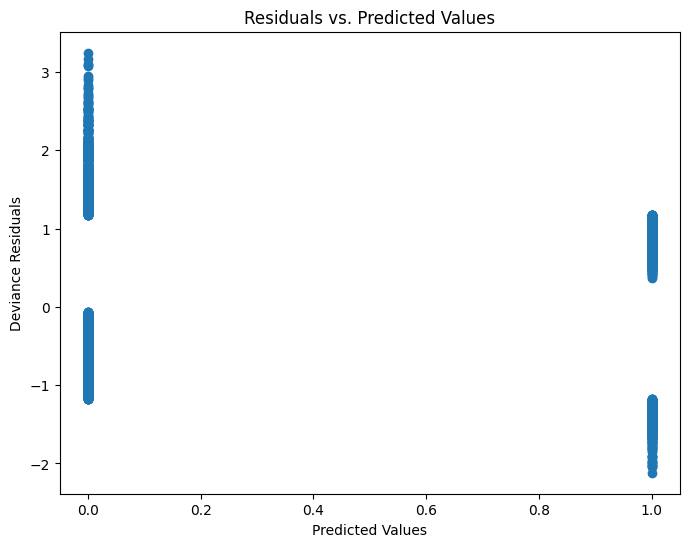

In [43]:
# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(gam.predict(X_train), gam.deviance_residuals(X_train, y_train))
plt.xlabel('Predicted Values')
plt.ylabel('Deviance Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

In [62]:
# Predictions
y_pred_train = gam.predict(X_train)
y_pred_test = gam.predict(X_test)

# Probabilities for ROC AUC
y_proba_train = gam.predict_proba(X_train)
y_proba_test = gam.predict_proba(X_test)

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# ROC AUC
train_auc = roc_auc_score(y_train, y_proba_train)
test_auc = roc_auc_score(y_test, y_proba_test)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")
print(f"Training ROC AUC: {train_auc:.2f}")
print(f"Testing ROC AUC: {test_auc:.2f}")

Training Accuracy: 0.81
Testing Accuracy: 0.81
Training ROC AUC: 0.85
Testing ROC AUC: 0.86


## Interpretation of Partial Dependency Plots (PDPs) for GAM

### 1. **Gender**
   - **Trend**: Slight negative
   - **Interpretation**: Gender has a minimal negative effect on churn, with one gender (likely male) slightly less likely to churn.

### 2. **Senior Citizen**
   - **Trend**: Positive
   - **Interpretation**: Senior citizens are more likely to churn, with a modest increase in the probability of churn.

### 3. **Partner**
   - **Trend**: Slight positive
   - **Interpretation**: Having a partner slightly increases the likelihood of churn, though the effect is small.

### 4. **Dependents**
   - **Trend**: Negative
   - **Interpretation**: Customers with dependents are less likely to churn, showing that family-oriented customers are more likely to stay.

### 5. **Tenure**
   - **Trend**: Strong negative
   - **Interpretation**: Longer tenure significantly reduces the likelihood of churn, especially in the first 20 months, where churn probability drops sharply.

### 6. **Paperless Billing**
   - **Trend**: Positive
   - **Interpretation**: Customers with paperless billing are more likely to churn. This may indicate a preference for traditional billing methods.

### 7. **Monthly Charges**
   - **Trend**: Strong positive
   - **Interpretation**: Higher monthly charges significantly increase the probability of churn. Customers paying more are much more likely to leave.

### 8. **Internet Service: Fiber Optic**
   - **Trend**: Slight positive
   - **Interpretation**: Customers using fiber optic services are marginally more likely to churn compared to other internet services.

### 9. **Contract Type**
   - **One Year Contract**:  
     - **Trend**: Negative  
     - **Interpretation**: One-year contracts reduce churn probability by a moderate amount.
   - **Two Year Contract**:  
     - **Trend**: Strong negative  
     - **Interpretation**: Two-year contracts greatly reduce churn, showing long-term commitments effectively retain customers.

### 10. **Payment Methods**
   - **Credit Card (Automatic)**:  
     - **Trend**: Slight negative  
     - **Interpretation**: Automatic credit card payments slightly reduce churn likelihood.
   - **Electronic Check**:  
     - **Trend**: Positive  
     - **Interpretation**: Customers paying via electronic check are more likely to churn.
   - **Mailed Check**:  
     - **Trend**: Slight negative  
     - **Interpretation**: Customers paying by mailed check have a small reduction in churn probability.

### 11. **Online Security**
   - **Trend**: Negative
   - **Interpretation**: Customers with online security services are less likely to churn, suggesting this service improves customer retention.

### 12. **Online Backup**
   - **Trend**: Negative
   - **Interpretation**: Customers with online backup services are less likely to churn, though the effect is moderate.

### 13. **Device Protection**
   - **Trend**: Slight negative
   - **Interpretation**: Customers with device protection services are marginally less likely to churn.

### 14. **Tech Support**
   - **Trend**: Strong negative
   - **Interpretation**: Having tech support significantly reduces churn likelihood, making it a key factor in customer retention.

### 15. **Streaming TV**
   - **Trend**: Flat to slightly negative
   - **Interpretation**: Streaming TV services slightly reduce churn probability, but the effect is minimal.

### 16. **Streaming Movies**
   - **Trend**: Flat to slight positive
   - **Interpretation**: Streaming movies has a negligible effect on churn, with a slight increase in churn probability.

### 17. **Multiple Lines: No Phone Service**
   - **Trend**: Strong positive
   - **Interpretation**: Customers without phone service are much more likely to churn. This suggests bundling phone services could help retain customers.

### 18. **Multiple Lines: Yes**
   - **Trend**: Slight positive
   - **Interpretation**: Customers with multiple lines are slightly more likely to churn, though the effect is small.

---

## Key Insights:

1. **Churn Reducing Features**:
   - **Tenure**: Longer tenure significantly reduces churn risk, especially in the first 20 months.
   - **Contract Length**: One- and two-year contracts greatly reduce churn, with longer contracts having a stronger effect.
   - **Support Services**: Features like **Tech Support**, **Online Security**, and **Device Protection** help retain customers.

2. **Churn Increasing Features**:
   - **Monthly Charges**: Higher monthly charges sharply increase churn probability, indicating price sensitivity.
   - **Paperless Billing**: Customers with paperless billing are more likely to churn, perhaps due to a desire for more traditional interactions.
   - **No Phone Service**: Customers without phone services are significantly more likely to churn, suggesting phone service bundling could be an effective retention strategy.

3. **Moderate and Negligible Effects**:
   - **Partner Status**, **Streaming TV**, and **Streaming Movies** have relatively small effects on churn probability.

Overall, **service-related features** (tenure, contracts, support) are the strongest factors driving churn, with pricing and service bundling playing a critical role in retaining customers.

## Model Comparison: Performance and Interpretability

| Model                         | Accuracy    | Precision (Churn) | Recall (Churn)  | F1-Score (Churn) | Interpretability               | Strengths                                         | Weaknesses                                      |
|-------------------------------|-------------|-------------------|-----------------|------------------|--------------------------------|--------------------------------------------------|------------------------------------------------|
| **Linear Regression**          | 81.85%      | 85.05%            | 91.31%          | 88.05%           | Medium - Coefficients indicate linear relationships. | High recall and precision, good at capturing churners. | High false positive rate, limited to linear relationships. |
| **Logistic Regression**        | 82.11%      | 69%               | 59%             | 63%              | High - Coefficients are easy to interpret for binary classification. | Simple, interpretable, identifies key drivers of churn. | Struggles with nonlinear relationships and imbalanced classes. |
| **Generalized Additive Model (GAM)** | 81.00%      | 70%               | 61%             | 65%              | Medium-High - Partial dependence plots offer detailed insights into feature effects. | Balances interpretability and flexibility, shows individual feature impacts on churn. | Requires more complex tuning and setup compared to Logistic Regression. |

---

## Interpretation of Model Performance and Interpretability:

### 1. **Linear Regression**
   - **Accuracy (81.85%)**: The model correctly predicts whether a customer will churn or not 81.85% of the time. While accuracy is relatively high, it doesn't account for class imbalances or the different costs of false positives and false negatives.
   - **Precision (85.05%)**: When the model predicts a customer will churn, it is correct 85.05% of the time. This indicates a low false positive rate among predicted positives.
   - **Recall (91.31%)**: The model correctly identifies 91.31% of all actual churn cases. High recall means the model is good at capturing the customers who will churn.
   - **Specificity (55.47%)**: The model correctly identifies 55.47% of the customers who will not churn. The model has a moderate ability to recognize customers who will stay, indicating a higher false positive rate.
   - **False Positive Rate (44.53%)**: 44.53% of the time, the model incorrectly predicts a customer will churn when they won't. This could lead to unnecessary retention efforts on customers unlikely to churn.
   - **False Negative Rate (8.69%)**: Only 8.69% of actual churners are missed by the model. This is beneficial for retention strategies as the model rarely fails to identify customers who will churn.
   - **F1 Score (88.05%)**: The model achieves a balance between precision and recall, with a strong F1 score, making it effective at identifying churners without too many false alarms.
   
   **Strengths**: 
   - High precision and recall for identifying churners.
   - Simple linear model, easy to interpret and implement.
   
   **Weaknesses**: 
   - High false positive rate, resulting in unnecessary retention efforts.
   - Assumes a linear relationship which may not capture complex patterns in the data.

### 2. **Logistic Regression**
   - **Accuracy (82.11%)**: Logistic Regression improves upon Linear Regression for binary classification tasks like churn prediction. It achieves a reasonable balance of precision and recall but struggles with slightly lower recall (59%).
   - **Confusion Matrix**:
     ```
     [[938  98]
      [154 219]]
     ```
     - **True Negatives (938)**: Correctly predicted non-churners.
     - **False Positives (98)**: Incorrectly predicted churners.
     - **False Negatives (154)**: Incorrectly predicted non-churners.
     - **True Positives (219)**: Correctly predicted churners.
   - **Precision (69%)**: When predicting churn, Logistic Regression is correct 69% of the time, but its lower recall indicates that it misses more actual churners.
   - **Recall (59%)**: It correctly identifies 59% of churn cases but misses a significant portion (false negatives).
   - **F1 Score (63%)**: Provides a balance between precision and recall but is lower than Linear Regression due to its lower recall.
   
   **Strengths**: 
   - Suitable for binary classification tasks like churn.
   - Interpretable with clear coefficients that provide insights into the odds of churn.
   
   **Weaknesses**: 
   - Struggles with imbalanced data and nonlinear relationships.
   - Lower recall means it may miss some churners.

### 3. **Generalized Additive Model (GAM)**
   - **Training Accuracy (81%)**: GAM achieves an accuracy of 81% on both training and testing sets, showing consistency in performance.
   - **Testing Accuracy (81%)**: The model generalizes well to unseen data.
   - **Training ROC AUC (0.85)**: The ROC AUC score indicates that the model is good at distinguishing between churners and non-churners.
   - **Testing ROC AUC (0.86)**: The ROC AUC remains strong on the test set, showing the model's robustness in identifying churners.
   - **Precision (70%)**: When GAM predicts churn, it's correct 70% of the time.
   - **Recall (61%)**: GAM captures 61% of actual churners, performing slightly better than Logistic Regression in recall.
   - **F1 Score (65%)**: A reasonable balance between precision and recall, making it a strong model for capturing churners with some flexibility.
   
   **Strengths**: 
   - Can model nonlinear relationships while remaining interpretable through partial dependence plots.
   - Good balance of performance and interpretability, with ROC AUC scores showing strong classification ability.
   
   **Weaknesses**: 
   - Requires more tuning and is more complex to interpret than Logistic Regression.
   - Not as easy to implement as Linear Regression.

---

## Recommendations for the Telecommunications Company:

### 1. **Logistic Regression for Simplicity and Actionable Insights**:
   - If the company's goal is to gain clear, actionable insights into **why** customers are churning, **Logistic Regression** is the best choice. It provides interpretable coefficients that explain the likelihood of churn, which can help in crafting data-driven business strategies.
   - **Recommendation**: Use Logistic Regression to understand churn drivers and make informed decisions for customer retention strategies.

### 2. **GAM for Flexibility and Detailed Feature Insights**:
   - **GAM** offers more flexibility than Logistic Regression by handling **nonlinearities** in the data while still being interpretable through **Partial Dependence Plots**. This allows the company to better understand how individual features influence churn.
   - **Recommendation**: Use GAM when the company needs a nuanced understanding of feature effects and when handling more complex relationships.

### 3. **Avoid Using Linear Regression**:
   - **Linear Regression** is not well-suited for binary classification tasks like churn. While it offers high precision and recall, its high false positive rate makes it less practical for this problem.
   - **Recommendation**: Avoid using Linear Regression for churn prediction, as it may lead to unnecessary retention efforts and doesn't handle binary outcomes as effectively as Logistic or GAM.

### Final Recommendation:
- The company should prioritize **Logistic Regression** for its simplicity and interpretability, especially when the focus is on understanding and addressing the key drivers of churn.
- **GAM** can be used in conjunction for a more flexible model that provides deeper insights into complex relationships.